In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
#accessing the dataset
DataDir = '/content/drive/MyDrive/FashionItems/data/RingFIR'
class_names = ['001','002','003','004','005','006','007','008','009','010','011','012','013','014','015','016',
               '017','018','019','020','021','022','023','024','025','026','027','028','029','030','031','032',
               '033','034','035','036','037','038','039','040','041','042','043','044','045','046']

In [4]:
#importing the necessary libraries
import matplotlib.pyplot as plt
import os
import cv2
import seaborn as sns
import numpy as np
import tensorflow as tf
import matplotlib
matplotlib.style.use('ggplot')
from sklearn.metrics import classification_report, confusion_matrix

In [5]:
pip install split-folders

In [6]:
#spliting the dataset into 80% of training set, 10% of testing set and 10% of validation set
import splitfolders
input_folder = '/content/drive/MyDrive/FashionItems/data/RingFIR'
splitfolders.ratio(input_folder, output="dataset", seed= 2615, ratio=(0.8, 0.1, 0.1))

Copying files: 2614 files [13:57,  3.12 files/s]


In [7]:
test_path = '/content/dataset/test'
train_path = '/content/dataset/train'
val_path = '/content/dataset/val'

In [ ]:
#define the shape of the images that we want to train on.
#the images will be resized accordingly before being fed into the neural network
#And  the images resized to 224×224 size
IMAGE_SHAPE = (224, 224)
TRAINING_DATA_DIR = '/content/dataset/train'
TEST_DATA_DIR = '/content/dataset/test'
VALID_DATA_DIR = '/content/dataset/val'

In [ ]:
#ImageDataGenerator class can handle the preprocessing of the images
#normalizing the images to scale the pixels between 0 and 1


datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255,
        rotation_range = 40,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True,
        brightness_range = (0.5, 1.5))

train_generator = train_datagen.flow_from_directory(
    TRAINING_DATA_DIR,
    shuffle=True,
    target_size=IMAGE_SHAPE,
)
test_generator = datagen.flow_from_directory(
    TEST_DATA_DIR,
    shuffle=False,
    target_size=IMAGE_SHAPE,
)
valid_generator = datagen.flow_from_directory(
    VALID_DATA_DIR,
    shuffle=False,
    target_size=IMAGE_SHAPE,
)

Found 2073 images belonging to 46 classes.
Found 300 images belonging to 46 classes.
Found 241 images belonging to 46 classes.


In [ ]:
y_train=train_generator.classes
y_test=test_generator.classes
y_val=valid_generator.classes

In [ ]:
#build a simple neural network model consisting of 2D Convolutional layers, 2D Max-Pooling layers, and Linear layers
#and Sequential class to build the model
def build_model(num_classes):
    model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=8, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(filters=128 , kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'), # linear 1d
    tf.keras.layers.Dense(num_classes, activation='softmax') # output
    ])
    return model
model = build_model(num_classes=46)

In [ ]:
#to compile the model I Use the Adam optimizer with a learning rate of 0.0001.
#and for the loss function, I use the Categorical Cross-Entropy loss. And the evaluation metric is accuracy.
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 8)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 111, 111, 8)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 16)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 54, 54, 16)        0

In [ ]:
#I am training for 50 epochs and the batch size is 32
# and the train_generator that will sample the training data and feed into the neural network.
#The validation_data and the validation_steps is the number of validation samples divided by the batch size.
#I provide verbose=1 to show the progress bar while training.
from tensorflow.keras.callbacks import EarlyStopping
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)
EPOCHS = 500
BATCH_SIZE = 32
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples // BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=valid_generator,
                    validation_steps= valid_generator.samples // BATCH_SIZE,
                    verbose=1,
                    callbacks=[early_stop],
                    shuffle=True
                    )

Epoch 1/500


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


 5/64 [=>............................] - ETA: 1:31 - loss: 4.6837 - accuracy: 0.0437

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


64/64 [==============================] - 105s 2s/step - loss: 3.8483 - accuracy: 0.0392 - val_loss: 3.8031 - val_accuracy: 0.0536
Epoch 2/500
64/64 [==============================] - 103s 2s/step - loss: 3.7265 - accuracy: 0.0421 - val_loss: 3.7807 - val_accuracy: 0.0491
Epoch 3/500
64/64 [==============================] - 105s 2s/step - loss: 3.7151 - accuracy: 0.0431 - val_loss: 3.7485 - val_accuracy: 0.0491
Epoch 4/500
64/64 [==============================] - 104s 2s/step - loss: 3.6939 - accuracy: 0.0407 - val_loss: 3.7429 - val_accuracy: 0.0580
Epoch 5/500
64/64 [==============================] - 104s 2s/step - loss: 3.6571 - accuracy: 0.0598 - val_loss: 3.6632 - val_accuracy: 0.0759
Epoch 6/500
64/64 [==============================] - 102s 2s/step - loss: 3.5883 - accuracy: 0.0789 - val_loss: 3.5374 - val_accuracy: 0.1205
Epoch 7/500
64/64 [==============================] - 103s 2s/step - loss: 3.4941 - accuracy: 0.0946 - val_loss: 3.4653 - val_accuracy: 0.1116
Epoch 8/500
64/64 

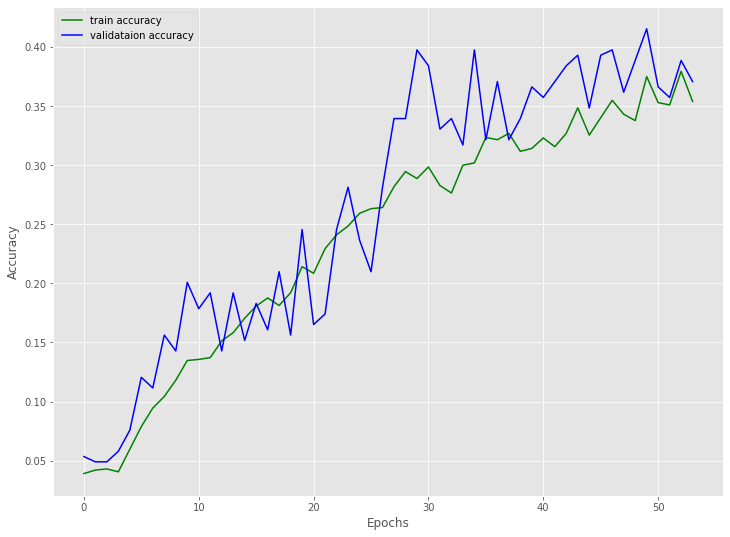

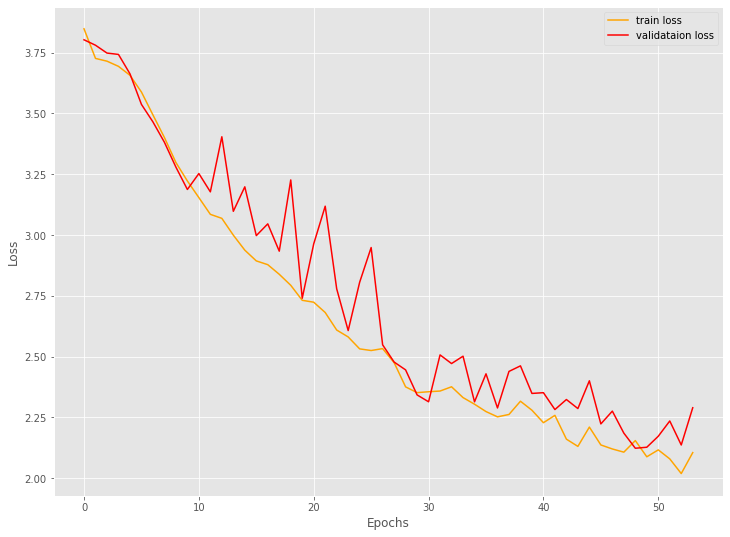

In [ ]:
#code to plot and save the accuracy and loss graphs for both training and validation.
train_loss = history.history['loss']
train_acc = history.history['accuracy']
valid_loss = history.history['val_loss']
valid_acc = history.history['val_accuracy']
def save_plots(train_acc, valid_acc, train_loss, valid_loss):
    """
    Function to save the loss and accuracy plots to disk.
    """
    # accuracy plots
    plt.figure(figsize=(12, 9))
    plt.plot(
        train_acc, color='green', linestyle='-',
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='blue', linestyle='-',
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('accuracy.png')
    plt.show()
    # loss plots
    plt.figure(figsize=(12, 9))
    plt.plot(
        train_loss, color='orange', linestyle='-',
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-',
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('loss.png')
    plt.show()
save_plots(train_acc, valid_acc, train_loss, valid_loss)

In [ ]:
y_pred = model.predict(test_generator)

10/10 [==============================] - 6s 561ms/step


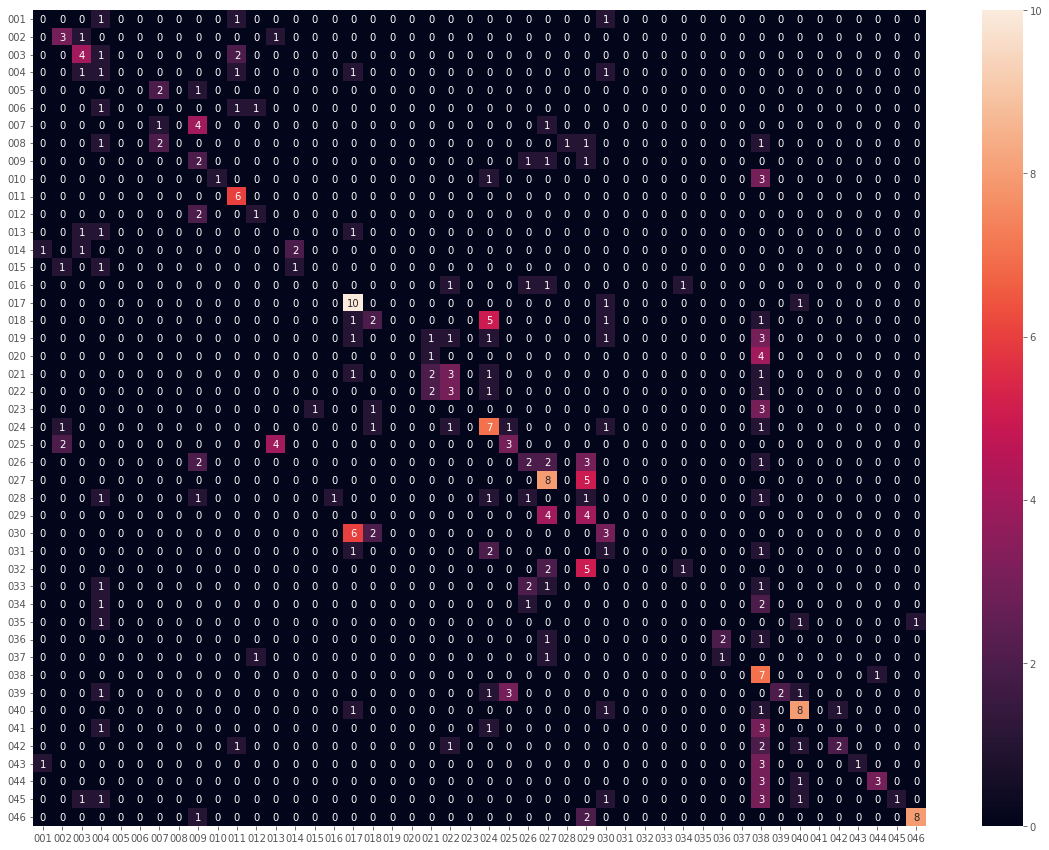

In [ ]:
#evaluate the model
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(20, 15))
y_pred_labels = [np.argmax(label) for label in y_pred ]
cm = confusion_matrix(y_test, y_pred_labels)

#show cm
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)

In [ ]:
from sklearn.metrics import classification_report
cr= classification_report (y_test, y_pred_labels, target_names=class_names)
print(cr)

              precision    recall  f1-score   support

         001       0.00      0.00      0.00         3
         002       0.43      0.60      0.50         5
         003       0.44      0.57      0.50         7
         004       0.07      0.20      0.11         5
         005       0.00      0.00      0.00         3
         006       0.00      0.00      0.00         3
         007       0.20      0.17      0.18         6
         008       0.00      0.00      0.00         6
         009       0.15      0.40      0.22         5
         010       1.00      0.20      0.33         5
         011       0.50      1.00      0.67         6
         012       0.33      0.33      0.33         3
         013       0.00      0.00      0.00         3
         014       0.67      0.50      0.57         4
         015       0.00      0.00      0.00         3
         016       0.00      0.00      0.00         4
         017       0.43      0.83      0.57        12
         018       0.33    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
